# 构建 Seq2seq + Attention 的新闻文本摘要

我们要使用 Sequence-To-Sequence(seq2seq) 模型，加上 Attention 机制，来制作一个新闻文本的摘要。


我们使用的数据是新浪新闻上的历史报道，以及针对这些新闻的短摘要数据。


* Sequence to sequence 模型
* TensorFlow 中的各种 Layer: 
  * 直接处理 Tensor
  * 自定义 Model 和 Layer
  * Attention 的可视化探索
    
在这个模型中，你将输入一篇完整的新闻，模型会自动返回针对这篇新闻的摘要内容。

## 需要额外安装的包

In [1]:
!pip install tensorflow_text tqdm jieba -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/60/7a/e881b5abb54db0e6e671ab088d079c57ce54e8a01a3ca443f561ccadb37e/typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.1
    Uninstalling typing-extensions-4.0.1:
      Successfully uninstalled typing-extensions-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
black 21.12b0 requires typing-extensions>=3.10.0.0, but you have typing-extensions 3.7.4.3 which is incompatible.


In [2]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
tf.config.experimental.set_visible_devices(devices=gpus[0:4], device_type="GPU")

In [3]:
import typing
import warnings
from datetime import datetime
from typing import Any, Tuple

warnings.filterwarnings("ignore")

import jieba
import matplotlib as mlt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import tensorflow as tf
import tensorflow_text as tf_text
from tensorflow.keras.layers.experimental import preprocessing

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号

%load_ext tensorboard

在我们手动实现一些机制的时候，会使用到很多的底层的 API，这些 API 很容易会出现 shape 的错误，所以我们定义一个类(ShapeChecker)用来检测这些 shape。

In [4]:
class ShapeChecker:
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)

        if rank != len(names):
            raise ValueError(
                f"Rank mismatch:\n"
                f"    found {rank}: {shape.numpy()}\n"
                f"    expected {len(names)}: {names}\n"
            )

        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]

            if broadcast and new_dim == 1:
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(
                    f"Shape mismatch for dimension: '{name}'\n"
                    f"    found: {new_dim}\n"
                    f"    expected: {old_dim}\n"
                )

## 数据探索

### 下载和准备数据

接下来，我们要下载数据集，并且把数据给准备好：

1. 在每个句子的开头和结尾增加一个 *start* 和一个 *end* token.
2. 清洗每个句子，去除一些我们不想要的文字.
3. 创建一个词表索引和倒索引 (dictionaries mapping from word → id and id → word).
4. Pad 每个句子到 maximum length.

In [5]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    "sina-article.zip",
    origin="http://aimaksen.bslience.cn/sina-article.zip",
    extract=True,
)

content_path = pathlib.Path(path_to_zip).parent / "train_text.txt"
title_path = pathlib.Path(path_to_zip).parent / "train_label.txt"

In [6]:
# Data clean and tokenize
from data_helper import build_news_data

train_save_path = pathlib.Path(".").parent / "data/sina-article-train.txt"
test_save_path = pathlib.Path(".").parent / "data/sina-article-test.txt"

In [7]:
build_news_data(content_path, title_path, train_save_path, test_save_path)

build data: 0it [00:00, ?it/s]Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Loading model from cache /tmp/jieba.cache
Loading model cost 0.516 seconds.
Prefix dict has been built successfully.
Loading model cost 0.525 seconds.
Loading model cost 0.524 seconds.
Loading model cost 0.525 seconds.
Prefix dict has been built succes

writing train data to file ...
writing test data to file ...


In [8]:
def load_data(path):
    text = path.read_text(encoding="utf-8")

    lines = text.splitlines()
    pairs = [line.split("\t") for line in lines]

    inp = [inp for inp, targ in pairs]
    targ = [targ for inp, targ in pairs]

    return inp, targ

In [9]:
inp, targ = load_data(train_save_path)
print(inp[-2])

1 . 动眼 — — 我们 的 眼睛 总是 看 外界 太 多 ， 看 心灵 太 少 。 2 . 动心 — — 幸福 只是 一种 感觉 ， 与 贫富 无关 ， 同 内心 相连 。 3 . 动脑 — — 说话 要 用 脑子 ， 做事 要 考虑 后果 。 4 . 动手 — — 少 指责 ， 少 抱怨 ， 少 后悔 。 5 . 动情 — — 既然 缺憾 不能 避免 ， 那么 用 什么 心态 来 对待 缺憾 就 非常 重要 。 @ 达 人 智慧 库  


In [10]:
print(targ[-2])

午休 分享 · 什么 是 幸福 ？


In [11]:
len(inp)

548422

In [12]:
## 为了演示，减小数据集规模
# inp = inp[:1000]
# targ = targ[:1000]

### 创建一个 tf.data dataset

从这些字符串的 arrays 我们可以创建 `tf.data.Dataset` 用来更高效的做 shuffle 和 batch:

In [13]:
BUFFER_SIZE = len(inp)
# 为了演示方便，减小了 Batch Size，通常我们可以从64开始尝试
BATCH_SIZE = 64

# .shuffle(BUFFER_SIZE) 为了演示，暂时没有使用 shuffle
dataset = (
    tf.data.Dataset.from_tensor_slices((inp, targ))
    .batch(BATCH_SIZE)
    .shuffle(BUFFER_SIZE)
)

In [14]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b'\xe8\xbf\x91\xe6\x97\xa5 \xef\xbc\x8c \xe4\xb8\xa4\xe5\x90\x8d \xe5\x8c\xbb\xe7\x94\x9f \xe7\x9d\xa1 \xe5\x80\x92 \xe5\x9c\xa8 \xe5\x9c\xb0\xe6\x9d\xbf \xe7\x9a\x84 \xe5\x9b\xbe\xe7\x89\x87 \xe5\x9c\xa8 \xe6\x9c\x8b\xe5\x8f\x8b\xe5\x9c\x88 \xe7\x81\xab \xe4\xba\x86 \xe3\x80\x82 3 \xe6\x9c\x88 7 \xe6\x97\xa5 \xef\xbc\x8c \xe8\xae\xb0\xe8\x80\x85 \xe4\xbb\x8e \xe4\xba\x91\xe5\x8d\x97\xe7\x9c\x81 \xe7\xac\xac\xe4\xb8\x80 \xe4\xba\xba\xe6\xb0\x91 \xe5\x8c\xbb\xe9\x99\xa2 \xe8\x8e\xb7\xe6\x82\x89 \xef\xbc\x8c \xe7\x85\xa7\xe7\x89\x87 \xe4\xb8\xad \xe7\x9a\x84 \xe4\xb8\xa4\xe5\x90\x8d \xe5\x8c\xbb\xe7\x94\x9f \xe4\xb8\xba \xe8\xaf\xa5\xe9\x99\xa2 \xe8\x82\x9d\xe8\x83\x86 \xe5\xa4\x96\xe7\xa7\x91 \xe7\x9a\x84 \xe7\x8e\x8b\xe6\xa2\x93\xe7\x91\x9c \xe4\xb8\x8e \xe5\x88\x98\xe6\x9e\x97 \xe3\x80\x82 \xe2\x80\x9c \xe5\xbd\x93\xe6\x97\xb6 \xe6\x98\xaf \xe7\xbb\x8f\xe8\xbf\x87 \xe6\x99\x9a\xe4\xb8\x8a \xe8\xbf\x91 \xe5\x85\xad\xe5\xb0\x8f\xe6\x97\xb6 \xe7\x9a\x84 \xe6\x89\x8b\xe6\x9c\x

In [15]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5].numpy()[0].decode("utf-8"))
    print()
    print(example_target_batch[:5].numpy()[0].decode("utf-8"))
    break

开场 8 分钟 ， 博阿滕为 德国队 首开纪录 ， 此后 戈麦斯 和 德 拉克斯 勒 又 各进 一球 ， 德国 战车 3 : 0 轻松 胜 斯洛伐克 。 德国队 1 / 4 决赛 对手 将 在 意大利 与 西班牙 之间 产生 。   秒 拍 视频   .  

德国 3 : 0 斯洛伐克


### 文本预处理

我们希望整个模型可以被 `tf.saved_model` 导出。为了能够导出模型，我们的输入应该是 `tf.string`，输出也是 `tf.string`。并且所有的预处理都能够在模型中处理。

#### 标准化

模型应该是能够处理多语言的文本，所以我们应该先对文本进行标准化(standardize)

使用 Unicode normalization 切割一些语言的发音符号和使用等价的 ASCII 替换复杂的字符。

`tensroflow_text` 中包含了 unicode normalize 的操作:

In [16]:
example_text = tf.constant("我爱 北京 天安门")

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, "NFKD").numpy())

b'\xe6\x88\x91\xe7\x88\xb1 \xe5\x8c\x97\xe4\xba\xac \xe5\xa4\xa9\xe5\xae\x89\xe9\x97\xa8'
b'\xe6\x88\x91\xe7\x88\xb1 \xe5\x8c\x97\xe4\xba\xac \xe5\xa4\xa9\xe5\xae\x89\xe9\x97\xa8'


Unicode 标准化会是文本标准化的第一步:

In [17]:
def preprocess(text):
    # Split accecented characters.
    text = tf_text.normalize_utf8(text, "NFKD")
    # text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation. 英文使用
    # text = tf.strings.regex_replace(text, "[^ a-z.?!,¿]", "")
    # Add spaces around punctuation.
    # text = tf.strings.regex_replace(text, "[.?!,¿]", r" \0 ")
    # Strip whitespace.
    text = tf.strings.strip(text)
    text = tf.strings.join(["[START]", text, "[END]"], separator=" ")
    return text

In [18]:
print(example_text.numpy().decode())
print(preprocess(example_text).numpy().decode())

我爱 北京 天安门
[START] 我爱 北京 天安门 [END]


#### 文本向量化

文本向量化的操作被封装在 [`preprocessing.TextVectorization`](https://keras.io/guides/preprocessing_layers/) layer 中，这层会从词典中抽取 token 并且把所有的文本转化成一个 token 的序列。

`TextVectorization` 和很多其他的 `experimental.preprocessing` 层都有一个 `adapt` 方法。这个方法能够读取一个 epoch 的训练数据，并且处理这些数据。这种行为有点像是 `Model.fit`.

>Working with lookup layers with very large vocabularies
You may find yourself working with a very large vocabulary in a TextVectorization, a StringLookup layer, or an IntegerLookup layer. Typically, a vocabulary larger than 500MB would be considered "very large".

>In such case, for best performance, you should avoid using adapt(). Instead, pre-compute your vocabulary in advance (you could use Apache Beam or TF Transform for this) and store it in a file. Then load the vocabulary into the layer at construction time by passing the filepath as the vocabulary argument.

In [19]:
text_processor = preprocessing.TextVectorization(
    standardize=preprocess, max_tokens=5000
)

In [20]:
# Take much time
text_processor.adapt(inp + targ)

In [21]:
# Here are the first 10 words from the vocabulary:
text_processor.get_vocabulary()[:10]

['', '[UNK]', ',', '的', '。', '[START]', '[END]', '“', '”', '、']

现在这些层可以把一些列的字符串转换成 token 的 IDs:

In [22]:
example_tokens = text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   5,    1,   79,  326,    2,    1,    1,    1,    2, 4060],
       [   5,    1,   42,  828,    1,    2, 2654,    1,  155, 1803],
       [   5,    1, 3055,    1,  222,    1,    9,    1,    7,    1]])>

`get_vocabulary` 方法可以把 IDs 再转换成文本:

In [23]:
vocab = np.array(text_processor.get_vocabulary())
tokens = vocab[example_tokens[0].numpy()]
" ".join(tokens)

'[START] [UNK] 8 分钟 , [UNK] [UNK] [UNK] , 此后 [UNK] 和 德 [UNK] [UNK] 又 [UNK] [UNK] , 德国 [UNK] 3 : 0 轻松 [UNK] [UNK] 。 [UNK] 1 / 4 决赛 对手 将 在 意大利 与 西班牙 之间 产生 。 秒 拍 视频 . [END]                                                                           '

这些返回的的 token IDs 被使用 0 进行了 pad, 我们可以很轻松的把它们转化成掩码的形式:

Text(0.5, 1.0, 'Mask')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


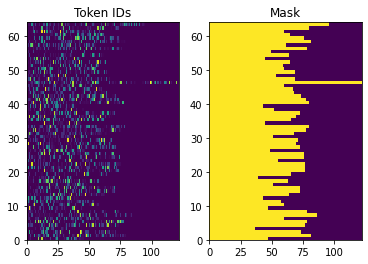

In [24]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title("Token IDs")

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title("Mask")

## Encoder/Decoder 模型

下面的图展示的是模型的概览。在每一个时间步 decoder 的输出都要和 encoder 的输出进行加权求和的操作，用来计算注意力。这张图出自 [Luong's paper](https://arxiv.org/abs/1508.04025v5).

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">


在开始定义模型之前，我们先来定义一些模型的超参数:

In [25]:
embedding_dim = 256
units = 1024

### Encoder

开始定义 Encoder，上图中蓝色的部分。

Encoder 流程:

1. 获取一个 token IDs 的列表 (从 `text_processor`).
3. Look up 每个 token 的 embedding 向量(使用`layers.Embedding`).
4. 把这些 embedding 转换成一个新的序列 (使用 `layers.GRU`).
5. 返回:
  * 处理过的序列，这会被传递给 attention head 用来计算注意力
  * 内部状态，这会用来初始化 decoder


In [26]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size, embedding_dim)

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(
            self.enc_units,
            # Return the sequence and state
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )

    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ("batch", "s"))

        # 2. The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)
        shape_checker(vectors, ("batch", "s", "embed_dim"))

        # 3. The GRU processes the embedding sequence.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ("batch", "s", "enc_units"))
        shape_checker(state, ("batch", "enc_units"))

        # 4. Returns the new sequence and its state.
        return output, state

我们把到目前为止的过程串起来:

In [27]:
# Convert the input text to tokens.
example_tokens = text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(text_processor.vocabulary_size(), embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f"Input batch, shape (batch): {example_input_batch.shape}")
print(f"Input batch tokens, shape (batch, s): {example_tokens.shape}")
print(f"Encoder output, shape (batch, s, units): {example_enc_output.shape}")
print(f"Encoder state, shape (batch, units): {example_enc_state.shape}")

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 122)
Encoder output, shape (batch, s, units): (64, 122, 1024)
Encoder state, shape (batch, units): (64, 1024)


Encoder 返回它的中间状态值，这个值用来初始化 Decoder。

我们通常也会多次调用 RNN 返回它的中间状态来处理一个序列。在 Decoder 的部分可以看到这样的使用方式。

### Attention head

Decoder 使用 attention 来选择把注意力放到输入的哪个部分上。

对于每一个样本，注意力把一个序列的向量作为输入，返回一个 "attention" 向量。这个 attention 层类似于 `layers.GlobalAveragePoling1D`，但是 attention 层执行的是 _weighted_ average

让我们看看它是怎么计算的:

<img src="https://www.tensorflow.org/text/tutorials/images/attention_equation_1.jpg" alt="attention equation 1" width="800">

<img src="https://www.tensorflow.org/text/tutorials/images/attention_equation_2.jpg" alt="attention equation 2" width="800">

符号:

* $s$ 是 encoder 索引.
* $t$ 是 decoder 索引.
* $\alpha_{ts}$ 是 attention weights.
* $h_s$ 是 encoder 序列的输出 (the attention "key" and "value" in transformer terminology).
* $h_t$ 是 decoder 状态 (the attention "query" in transformer terminology).
* $c_t$ 是 context 向量的计算结果.
* $a_t$ 是 最终的输出结合 the "context" and "query".

计算公式:

1. 计算注意力权重, $\alpha_{ts}$, 使用 softmax 应用在 encoder 的输出上.
2. 使用 weighted sum 计算上下文向量综合 encoder 的输出.


最后是 $score$ 函数. 它的工作是对于每个 key-query 计算它们的 logit-score 标量。 主要有两种方式: 

<img src="https://www.tensorflow.org/text/tutorials/images/attention_equation_4.jpg" alt="attention equation 4" width="800">

This tutorial uses [Bahdanau's additive attention](https://arxiv.org/pdf/1409.0473.pdf). TensorFlow 实现了  `layers.Attention` and `layers.AdditiveAttention`. 下面类的实现使用权重矩阵在 `layers.Dense` 层，然后使用了 `layers.AdditiveAttention` 完成 attention 的计算。

In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # For Eqn. (4), the  Bahdanau attention
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ("batch", "t", "query_units"))
        shape_checker(value, ("batch", "s", "value_units"))
        shape_checker(mask, ("batch", "s"))

        # From Eqn. (4), `W1@ht`.
        w1_query = self.W1(query)
        shape_checker(w1_query, ("batch", "t", "attn_units"))

        # From Eqn. (4), `W2@hs`.
        w2_key = self.W2(value)
        shape_checker(w2_key, ("batch", "s", "attn_units"))

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True,
        )
        shape_checker(context_vector, ("batch", "t", "value_units"))
        shape_checker(attention_weights, ("batch", "t", "s"))

        return context_vector, attention_weights

### 测试 Attention 层

创建 `BahdanauAttention` 层:

In [29]:
attention_layer = BahdanauAttention(units)

这层包含 3 个输入:

* `query`: 这个是从解码器生成的
* `value`: 这个是编码器的输出
* `mask`: 用来掩盖掉 padding 的部分 `example_tokens != 0`

In [30]:
(example_tokens != 0).shape

TensorShape([64, 122])

向量化实现的 attention 层能够让你把一个 batch 序列的 query 和 value，同时进行计算:

1. batch 的 query
2. batch 的 attention map `(query_length, value_length)`.

In [31]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query, value=example_enc_output, mask=(example_tokens != 0)
)

print(
    f"Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}"
)
print(
    f"Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}"
)

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 122)


对于每个序列，attention weights 的加和是 `1.0`

下面是 `t=0` 时刻的 attention weights

Text(0.5, 1.0, 'Mask')

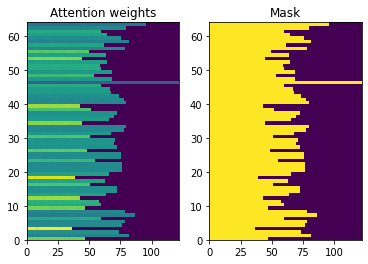

In [32]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title("Attention weights")

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title("Mask")

由于 attention weights 的初始化是一个随机的过程，所以刚开始的时候权重都是比较接近 `1/(sequence_length)` 的。如果放大一个序列的权重值，就可以看到这里已经有些非常小的 variation 是模型学习得到的。

In [33]:
attention_weights.shape

TensorShape([64, 2, 122])

In [34]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

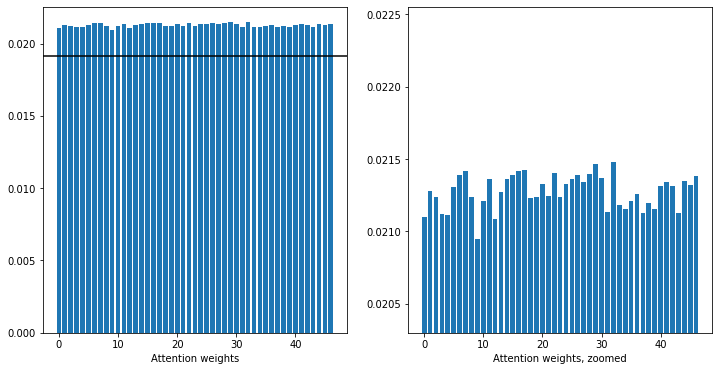

In [35]:
# @title
plt.suptitle("Attention weights for one sequence")

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel("Attention weights")

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel("Attention weights, zoomed")

# zoom in
top = max(a1.get_ylim())
zoom = 0.85 * top
a2.set_ylim([0.90 * top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color="k")

### Decoder

Decoder 的任务就是来预测/生成接下来输出的 token

1. decoder 会接收所有的 encoder 的输出
2. 使用 RNN 来跟踪当前已经生成的内容
3. 使用 RNN 的输出作为 query 和 encoder 的输出生成 context vector 
4. 联合 RNN 的输出和 context vector 使用 Equation 3 生成 "attention vector"
5. 根据 "attention vector" 生成 logit 预测下一个 token 

<img src="https://www.tensorflow.org/text/tutorials/images/attention_equation_3.jpg" alt="attention equation 3" width="800">


下面是 `Decoder` 类:

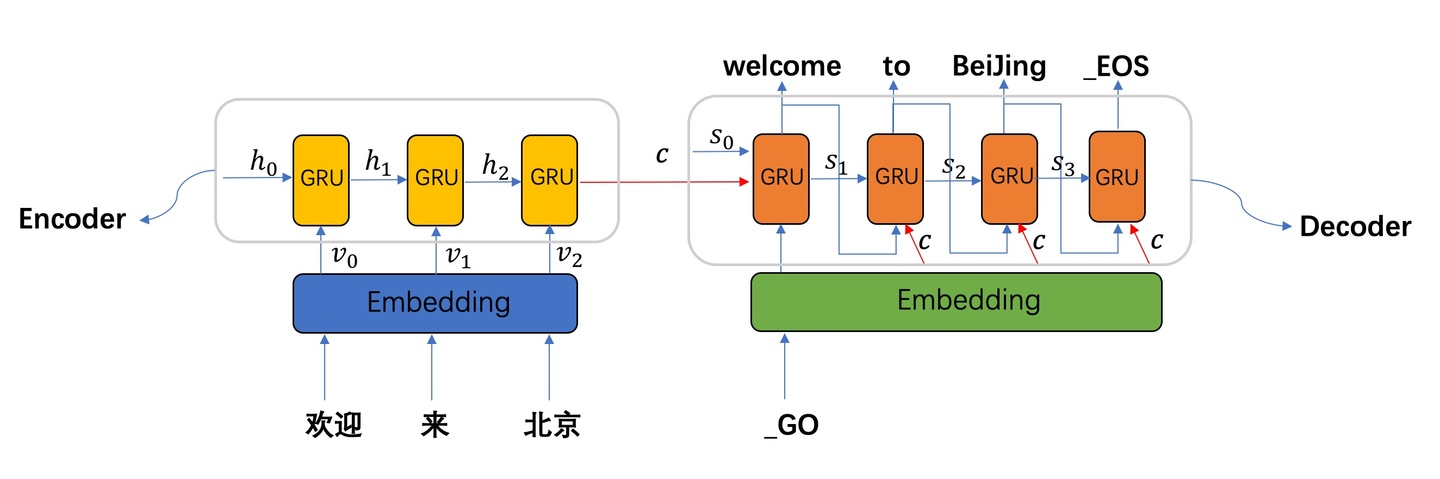

In [36]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # For Step 1. The embedding layer convets token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(
            self.output_vocab_size, embedding_dim
        )

        # For Step 2. The RNN keeps track of what's been generated so far.
        self.gru = tf.keras.layers.GRU(
            self.dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )

        # For step 3. The RNN output will be the query for the attention layer.
        self.attention = BahdanauAttention(self.dec_units)

        # For step 4. Eqn. (3): converting `ct` to `at`
        self.Wc = tf.keras.layers.Dense(
            dec_units, activation=tf.math.tanh, use_bias=False
        )

        # For step 5. This fully connected layer produces the logits for each
        # output token.
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

这层的 `call` 方法输入和输出多个 tensor。我们把它们组织成一个容器类:

In [37]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any


class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

下面是 `call` 方法的实现:

In [38]:
def call(self, inputs: DecoderInput, state=None) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ("batch", "t"))
    shape_checker(inputs.enc_output, ("batch", "s", "enc_units"))
    shape_checker(inputs.mask, ("batch", "s"))

    if state is not None:
        shape_checker(state, ("batch", "dec_units"))

    # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ("batch", "t", "embedding_dim"))

    # Step 2. Process one step with the RNN
    rnn_output, state = self.gru(vectors, initial_state=state)

    shape_checker(rnn_output, ("batch", "t", "dec_units"))
    shape_checker(state, ("batch", "dec_units"))

    # Step 3. Use the RNN output as the query for the attention over the
    # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask
    )
    shape_checker(context_vector, ("batch", "t", "dec_units"))
    shape_checker(attention_weights, ("batch", "t", "s"))

    # Step 4. Eqn. (3): Join the context_vector and rnn_output
    #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ("batch", "t", "dec_units"))

    # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
    shape_checker(logits, ("batch", "t", "output_vocab_size"))

    return DecoderOutput(logits, attention_weights), state

In [39]:
Decoder.call = call

**encoder** 在一次的 `call` 方法的调用过程中处理它的所有的输入。

**decoder** 也可以使用这种方式进行高效的训练。但是，这里我们选择使用 loop 来运行 decoder，这里我们有以下的原因:

* 灵活: 写训练给我们对于训练的直接控制。Writing the loop gives you direct control over the training procedure.
* 清晰: 可以使用 masking 的 tricks 

接下来，让我们来试试 decoder

In [40]:
decoder = Decoder(text_processor.vocabulary_size(), embedding_dim, units)

decoder 使用 4 个输入:

* `new_tokens` -  上一个生成的 token. 使用 `"[START]"` 作为 decoder 的初始化 
* `enc_output` - `Encoder` 生成的部分.
* `mask` - 一个布尔型的 tensor 用来表示 `tokens != 0` 的位置
* `state` - 之前的  `state`， 从 decoder 获取到的输出 (the internal state
  of the decoder's RNN). 输入 `None` 使用  zero-initialize. 原始的 paper 是使用 encoder RNN 生成的最终输入最为它的初始化。

In [41]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = text_processor(example_target_batch)

start_index = text_processor.get_vocabulary().index("[START]")
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [42]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs=DecoderInput(
        new_tokens=first_token,
        enc_output=example_enc_output,
        mask=(example_tokens != 0),
    ),
    state=example_enc_state,
)

print(f"logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}")
print(f"state shape: (batch_size, dec_units) {dec_state.shape}")

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


从上面这些 logits 中采样一个 token.

In [43]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

解码 token 作为输出的第一个单词。

In [44]:
vocab = np.array(text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['足够'],
       ['超市'],
       ['口罩'],
       ['年度'],
       ['逝世']], dtype='<U7')

接下来我们使用 decoder 来生成第二个 logits.

- 输入相同的 `enc_output` 和 `mask`, 这些并没有改变
- 输入采样的 token 作为 `new_tokens`.
- 输入上一个时刻 decoder 返回的 `decoder_state`, 这样 RNN 能够继续的保持之前时间的记忆。

In [45]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token, example_enc_output, mask=(example_tokens != 0)),
    state=dec_state,
)

In [46]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['股'],
       ['常州'],
       ['和'],
       ['年度'],
       ['底线']], dtype='<U7')

## 训练

现在我们已经有了所有的模型组件，我们可以开始训练模型了，我们需要:

- 一个 loss function 和 optimizer 
- 一个 training step function 用来定义针对于每个 input/target 如何更新模型。
- 一个训练 loop 用来进行训练和保存 checkpoints 

### 定义 loss function

In [47]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = "masked_loss"
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction="none"
        )

    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ("batch", "t"))
        shape_checker(y_pred, ("batch", "t", "logits"))

        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ("batch", "t"))

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ("batch", "t"))
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)

### 实现 training step

实现 `train_step` 方法. 更多自定义方法可以参看 [Customizing fit](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) 

这里 `train_step` 方法是 `_train_step` 的 wrapper，`_train_step` 使我们后面要实现的方法. 这个包装器包含一个打开和关闭 `tf.function`的开关，方便我们进行 debug

In [48]:
class TrainSummaryWriter(tf.keras.Model):
    def __init__(
        self,
        embedding_dim,
        units,
        input_text_processor,
        output_text_processor,
        use_tf_function=True,
    ):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()

    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()
        # 加速的场景
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            # 不加速的
            return self._train_step(inputs)

`Model.train_step` 方法的大概实现如下: 

1. 从 `tf.data.Dataset` 接收 a batch of `input_text, target_text` 
2. 转换这些 raw text inputs 为 token-embeddings 和 masks
3. 在 `input_tokens` 上运行 encoder 去获取 `encoder_output` 和 `encoder_state`.
4. 初始化 decoder 状态和 loss
5. 循环 `target_tokens`:
   1. 每个时间步调用 decoder one step.
   2. 对于每一个时间步计算 loss
   3. 积累平均的 loss 
6. 计算 loss 的梯度，使用 optimizer 把更新到模型的 `trainable_variables`


`_preprocess` 方法, 实现 steps #1 and #2: 

In [49]:
def _preprocess(self, input_text, target_text):
    self.shape_checker(input_text, ("batch",))
    self.shape_checker(target_text, ("batch",))

    # Convert the text to token IDs
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    self.shape_checker(input_tokens, ("batch", "s"))
    self.shape_checker(target_tokens, ("batch", "t"))

    # Convert IDs to masks.
    input_mask = input_tokens != 0
    self.shape_checker(input_mask, ("batch", "s"))

    target_mask = target_tokens != 0
    self.shape_checker(target_mask, ("batch", "t"))

    return input_tokens, input_mask, target_tokens, target_mask

In [50]:
TrainSummaryWriter._preprocess = _preprocess

`_train_step` 方法, 处理其余的 steps，除了实际运行 decoder:

In [51]:
def _train_step(self, inputs):
    input_text, target_text = inputs

    (input_tokens, input_mask, target_tokens, target_mask) = self._preprocess(
        input_text, target_text
    )

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:
        # Encode the input
        enc_output, enc_state = self.encoder(input_tokens)
        self.shape_checker(enc_output, ("batch", "s", "enc_units"))
        self.shape_checker(enc_state, ("batch", "enc_units"))

        # Initialize the decoder's state to the encoder's final state.
        # This only works if the encoder and decoder have the same number of
        # units.
        dec_state = enc_state
        loss = tf.constant(0.0)

        for t in tf.range(max_target_length - 1):
            # Pass in two tokens from the target sequence:
            # 1. The current input to the decoder.
            # 2. The target for the decoder's next prediction.
            new_tokens = target_tokens[:, t : t + 2]
            step_loss, dec_state = self._loop_step(
                new_tokens, input_mask, enc_output, dec_state
            )
            loss = loss + step_loss

        # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {"batch_loss": average_loss}

In [52]:
TrainSummaryWriter._train_step = _train_step

`_loop_step` 方法, 运行 decoder 并且计算递增的 loss 和 decoder 的新的 state (`dec_state`).

In [53]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(
        new_tokens=input_token, enc_output=enc_output, mask=input_mask
    )

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    self.shape_checker(dec_result.logits, ("batch", "t1", "logits"))
    self.shape_checker(dec_result.attention_weights, ("batch", "t1", "s"))
    self.shape_checker(dec_state, ("batch", "dec_units"))

    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

In [54]:
TrainSummaryWriter._loop_step = _loop_step

### 测试训练 step

训练一个 `TrainSummaryWriter`, 并且使用 `Model.compile` 配置它: 

In [55]:
writer = TrainSummaryWriter(
    embedding_dim,
    units,
    input_text_processor=text_processor,
    output_text_processor=text_processor,
    use_tf_function=False,
)

# Configure the loss and optimizer
writer.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

测试 `train_step`. 对于一个文本模型一开始的时候 loss 应该接近于下面的值:

In [56]:
np.log(text_processor.vocabulary_size())

8.517193191416238

In [57]:
%%time
for n in range(10):
    print(writer.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.8233404>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.7651205>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5906396>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.8126435>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=9.123618>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.888087>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.184248>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.709961>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.42888>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1981254>}

CPU times: user 4.41 s, sys: 50 ms, total: 4.46 s
Wall time: 4.44 s


让我们来使用 `tf.function` 包装 `_tf_train_step` 提高训练的最大效率:

In [58]:
@tf.function(
    input_signature=[
        [
            tf.TensorSpec(dtype=tf.string, shape=[None]),
            tf.TensorSpec(dtype=tf.string, shape=[None]),
        ]
    ]
)
def _tf_train_step(self, inputs):
    return self._train_step(inputs)

In [59]:
TrainSummaryWriter._tf_train_step = _tf_train_step

In [60]:
writer.use_tf_function = True

第一次执行会比较的慢，应为它会追踪函数:

In [61]:
%%time
writer.train_step([example_input_batch, example_target_batch])

CPU times: user 4.36 s, sys: 189 ms, total: 4.55 s
Wall time: 3.66 s


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.961482>}

但是，之后通常能得到比普通 `train_step` 2-3x 倍的提升 

In [62]:
%%time
for n in range(10):
    print(writer.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9099283>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9450006>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9937508>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0260572>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.032317>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.003757>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.945531>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.87374>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8119447>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7786825>}

CPU times: user 12.4 s, sys: 1.71 s, total: 14.1 s
Wall time: 4.46 s


对于一个新模型，一个很好的测试方法就是看看能够 overfit 一个 batch 的输入。如果，loss 可以快速的收敛到 0，说明这个模型没有问题:

....................................................................................................


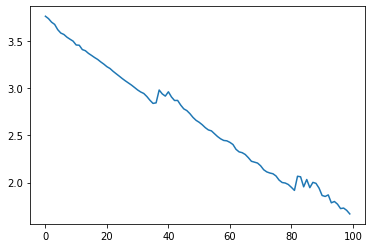

In [63]:
losses = []
for n in range(100):
    print(".", end="")
    logs = writer.train_step([example_input_batch, example_target_batch])
    losses.append(logs["batch_loss"].numpy())

print()
plt.plot(losses)

测试完之后，我们非常确信这个训练是能够 work 的，构建一个模型的副本来自由的进行手动的训练:

In [64]:
train_writer = TrainSummaryWriter(
    embedding_dim,
    units,
    input_text_processor=text_processor,
    output_text_processor=text_processor,
)

# Configure the loss and optimizer
train_writer.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### 训练模型


当我们写自定义的训练 loop 没有问题之后， 我们就可以实现 `Model.train_step` 就像前面的 section 一样，这样能够让我们使用 `Model.fit` 来进行模型的训练，避免写很多重复的代码


接下来使用 `callbacks.Callback` 来收集 batch losses 的历史数据，并且画图:

In [65]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])


batch_loss = BatchLogs("batch_loss")

# Define the Keras TensorBoard callback.
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
train_writer.fit(dataset, epochs=20, callbacks=[batch_loss, tensorboard_callback])

Epoch 1/20
8570/8570 [==============================] - 4147s 483ms/step - batch_loss: 3.1032
Epoch 2/20
8570/8570 [==============================] - 4209s 491ms/step - batch_loss: 2.4037
Epoch 3/20
8570/8570 [==============================] - 4214s 492ms/step - batch_loss: 2.2000
Epoch 4/20
8570/8570 [==============================] - 4080s 476ms/step - batch_loss: 2.0414
Epoch 5/20
6894/8570 [=======================>......] - ETA: 13:23 - batch_loss: 1.8939

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel("Batch #")
plt.ylabel("CE/token")

The visible jumps in the plot are at the epoch boundaries.

## 写摘要

现在，我们的模型已经训练好了，我们要实现一个完整的执行 `text => text` 对文章进行摘要的方法.

对于这个模型，我们需要把 `text => token IDs` 的过程给倒过来，我们使用 `text_processor`，它需要知道每一个 token 的 IDs。这些都会在下面进行实现。

总体上，这和 training loop 很相似，除了 decoder 在每一个时间步的输入都是之前时间步的预测.

In [ ]:
class SummaryWriter(tf.Module):
    def __init__(self, encoder, decoder, input_text_processor, output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor

        self.output_token_string_from_index = (
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token="",
                invert=True,
            )
        )

        # The output should never generate padding, unknown, or start.
        index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token=""
        )
        token_mask_ids = index_from_string(["", "[UNK]", "[START]"]).numpy()

        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant("[START]"))
        self.end_token = index_from_string(tf.constant("[END]"))

In [ ]:
writer = SummaryWriter(
    encoder=train_writer.encoder,
    decoder=train_writer.decoder,
    input_text_processor=text_processor,
    output_text_processor=text_processor,
)

### 把 IDs 转换为文本

第一个时间的方法是 `tokens_to_text` 可以把 token IDs 转化为人类可读的文本.

In [ ]:
def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ("batch", "t"))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ("batch", "t"))

    result_text = tf.strings.reduce_join(result_text_tokens, axis=1, separator=" ")
    shape_checker(result_text, ("batch"))

    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ("batch",))
    return result_text

In [ ]:
SummaryWriter.tokens_to_text = tokens_to_text

随机生产一些 IDs，看看它能转换成什么:

In [ ]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64, maxval=text_processor.vocabulary_size()
)
writer.tokens_to_text(example_output_tokens).numpy()

### 从 Decoder 的预测中进行采样

接下来的方法，要从获取 decoder 的 logit，并且从这个分布中采样 token IDs:

In [ ]:
def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    # 't' is usually 1 here.
    shape_checker(logits, ("batch", "t", "vocab"))
    shape_checker(self.token_mask, ("vocab",))

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ("batch", "t", "vocab"), broadcast=True)

    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else:
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits / temperature, num_samples=1)

    shape_checker(new_tokens, ("batch", "t"))

    return new_tokens

In [ ]:
SummaryWriter.sample = sample

测试在这个函数上跑一些随机的输入:

In [ ]:
example_logits = tf.random.normal([5, 1, text_processor.vocabulary_size()])
example_output_tokens = writer.sample(example_logits, temperature=1.0)
example_output_tokens

### 实现完整的写摘要的循环

接下来是文本到摘要的完整实现。

这个实现会在收集所有的结果到 python 的 list 之前，使用 `tf.concat` 把它们合并并且转化为 tensor.

这个实现会静态的展开到 `max_length` 长度.

In [ ]:
def write_unrolled(
    self, input_text, *, max_length=50, return_attention=True, temperature=1.0
):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)

    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)

    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    for _ in range(max_length):
        dec_input = DecoderInput(
            new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0)
        )

        dec_result, dec_state = self.decoder(dec_input, state=dec_state)

        attention.append(dec_result.attention_weights)

        new_tokens = self.sample(dec_result.logits, temperature)

        # If a sequence produces an `end_token`, set it `done`
        done = done | (new_tokens == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

        # Collect the generated tokens
        result_tokens.append(new_tokens)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Convert the list of generates token ids to a list of strings.
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)

    if return_attention:
        attention_stack = tf.concat(attention, axis=1)
        return {"text": result_text, "attention": attention_stack}
    else:
        return {"text": result_text}

In [ ]:
SummaryWriter.write = write_unrolled

在一个简单的输入上运行它:

In [ ]:
%%time
input_text = tf.constant(
    [
        "今天 凌晨 零点 左右 ， 在 南京 秦淮区 马道 街华静 家园 小区 ， 保安 于 师傅 发现 有 一 男子 坐在 一楼 门面房 屋顶 上 。 询问 得知 他 住 在 这幢 居民楼 2 楼 ， 之前 偷偷 从 窗户 爬出来 透气 ， 可不 知情 的 父母亲 在 外出 时 反锁 了 门窗 ， 他 有家 回 不了 。   （ 分享 自   @ 江苏 网络 电视台 ）",
        "今日 ， 中国 大陆 正式 发售 新一代 iPhone5S 和 5C 。 记者 了解 到 ， 第一批 苹果 5S 已于 昨日 傍晚 提前 在 一些 授权 经销店 亮相 ， 并 于 今日 开卖 。 这是 中国 大陆 首次 与 全球 同步 发售 。 “ 5S ” 目前 在 行货 市场 和 水货 市场 都 是 “ 一机 难求 ” ， 金色 版 报价 甚至 过万 。",
    ]
)

result = writer.write(input_text=input_text)

print(result["text"][0].numpy().decode())
print(result["text"][1].numpy().decode())
print()

如果想要导出这个模型，我们需要把这个方法包装在 `tf.function` 中，这个基本的实现在尝试的过程中会存在一些问题:

1. 这种生成的 DAG 会非常的大，当我们存储和加载的时候会比较花时间 
2. 我们不能打断它静态的展开，它会一直跑到 `max_length`，即使所有的输出都完成了。但是，即使这样它也会比 eager execution 更快。


In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_write(self, input_text):
    return self.write(input_text)


SummaryWriter.tf_write = tf_write

执行 `tf.function` 来进行编译:

In [ ]:
%%time
result = writer.tf_write(input_text=input_text)

In [ ]:
%%time
result = writer.tf_write(input_text=input_text)

print(result["text"][0].numpy().decode())
print(result["text"][1].numpy().decode())
print()

In [ ]:
# @title [Optional] Use a symbolic loop
def write_symbolic(
    self, input_text, *, max_length=50, return_attention=True, temperature=1.0
):
    shape_checker = ShapeChecker()
    shape_checker(input_text, ("batch",))

    batch_size = tf.shape(input_text)[0]

    # Encode the input
    input_tokens = self.input_text_processor(input_text)
    shape_checker(input_tokens, ("batch", "s"))

    enc_output, enc_state = self.encoder(input_tokens)
    shape_checker(enc_output, ("batch", "s", "enc_units"))
    shape_checker(enc_state, ("batch", "enc_units"))

    # Initialize the decoder
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)
    shape_checker(new_tokens, ("batch", "t1"))

    # Initialize the accumulators
    result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
    attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    shape_checker(done, ("batch", "t1"))

    for t in tf.range(max_length):
        dec_input = DecoderInput(
            new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0)
        )

        dec_result, dec_state = self.decoder(dec_input, state=dec_state)

        shape_checker(dec_result.attention_weights, ("batch", "t1", "s"))
        attention = attention.write(t, dec_result.attention_weights)

        new_tokens = self.sample(dec_result.logits, temperature)
        shape_checker(dec_result.logits, ("batch", "t1", "vocab"))
        shape_checker(new_tokens, ("batch", "t1"))

        # If a sequence produces an `end_token`, set it `done`
        done = done | (new_tokens == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

        # Collect the generated tokens
        result_tokens = result_tokens.write(t, new_tokens)

        if tf.reduce_all(done):
            break

    # Convert the list of generated token ids to a list of strings.
    result_tokens = result_tokens.stack()
    shape_checker(result_tokens, ("t", "batch", "t0"))
    result_tokens = tf.squeeze(result_tokens, -1)
    result_tokens = tf.transpose(result_tokens, [1, 0])
    shape_checker(result_tokens, ("batch", "t"))

    result_text = self.tokens_to_text(result_tokens)
    shape_checker(result_text, ("batch",))

    if return_attention:
        attention_stack = attention.stack()
        shape_checker(attention_stack, ("t", "batch", "t1", "s"))

        attention_stack = tf.squeeze(attention_stack, 2)
        shape_checker(attention_stack, ("t", "batch", "s"))

        attention_stack = tf.transpose(attention_stack, [1, 0, 2])
        shape_checker(attention_stack, ("batch", "t", "s"))

        return {"text": result_text, "attention": attention_stack}
    else:
        return {"text": result_text}

In [ ]:
SummaryWriter.write = write_symbolic

初始化的使用的是 python lists 来收集输出. 接下来，我们会使用 `tf.range` 作为 loop 迭代器，允许  `tf.autograph` 转化这个 loop。这种实现的最大改变是，使用了 `tf.TensorArray` 来替代 python `list` 获取结果。在 graph mode，`tf.TensorArray` 需要收集一个数字类型的 tensor。

在 eager 模式下，这种实现作为一个标准计量:

In [ ]:
%%time
result = writer.write(input_text=input_text)

print(result["text"][0].numpy().decode())
print(result["text"][1].numpy().decode())
print()

但是，当我们把它包装在 `tf.function` 我们需要知道它有两个不同。

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_write(self, input_text):
    return self.write(input_text)


SummaryWriter.tf_write = tf_write

首先，图创建会更快（~10x）,并且它也不会创建 `max_iterations` 次模型的拷贝。

In [ ]:
%%time
result = writer.tf_write(input_text=input_text)

其次，编译的函数在小的输入上会获得更快的速度  (5x on this example)，因为它可以在 loop 中进行打断。

In [ ]:
%%time
result = writer.tf_write(input_text=input_text)

print(result["text"][0].numpy().decode())
print(result["text"][1].numpy().decode())
print()

### 可视化执行

attention weights 会在 `write` 方法中返回回来，表明模型在生成的时候注意力放在哪里。

所以，每个序列的的注意力之和为 1.

In [ ]:
a = result["attention"][0]

print(np.sum(a, axis=-1))

下面这张图是第一个样本的输出的第一个时间步。我们可以看到，这个注意力已经比没训练时要更加的"专注"了。


In [ ]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

到这里，我们已经能看到一些粗糙的对齐了，我们希望注意力能够聚焦在对角线上:

In [ ]:
plt.imshow(np.array(a), vmin=0.0)

下面是一个更好的 attention 的可视化的绘图:

In [ ]:
# @title Labeled attention plots
def plot_attention(attention, sentence, predicted_sentence):
    sentence = preprocess(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ["[END]"]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    attention = attention[: len(predicted_sentence), : len(sentence)]

    ax.matshow(attention, cmap="viridis", vmin=0.0)

    fontdict = {"fontsize": 14}

    ax.set_xticklabels([""] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([""] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel("Input text")
    ax.set_ylabel("Output text")
    plt.suptitle("Attention weights")

In [ ]:
i = 0
plot_attention(result["attention"][i], input_text[i], result["text"][i])

In [ ]:
mlt.get_cachedir()

接下来，对几个例子做一下摘要，并且画一下 attention 情况:

In [ ]:
%%time
three_input_text = tf.constant(
    [
        # This is my life.
        "今天 凌晨 零点 左右 ， 在 南京 秦淮区 马道 街华静 家园 小区 ， 保安 于 师傅 发现 有 一 男子 坐在 一楼 门面房 屋顶 上 。 询问 得知 他 住 在 这幢 居民楼 2 楼 ， 之前 偷偷 从 窗户 爬出来 透气 ， 可不 知情 的 父母亲 在 外出 时 反锁 了 门窗 ， 他 有家 回 不了 。   （ 分享 自   @ 江苏 网络 电视台 ）",
        # Are they still home?
        "今日 ， 中国 大陆 正式 发售 新一代 iPhone5S 和 5C 。 记者 了解 到 ， 第一批 苹果 5S 已于 昨日 傍晚 提前 在 一些 授权 经销店 亮相 ， 并 于 今日 开卖 。 这是 中国 大陆 首次 与 全球 同步 发售 。 “ 5S ” 目前 在 行货 市场 和 水货 市场 都 是 “ 一机 难求 ” ， 金色 版 报价 甚至 过万 。",
        # Try to find out.'
        "4 月 1 日起 ， 公交 集团 公布 76 条 公交 “ 定点 班线 ” 的 行车 计划 。 “ 定点 班线 ” 是 指 线路 客流量 小 ， 有 一定 出行 需求 ， 计划 发车 间隔 较大 的 公交线路 。 市民 可 通过 车厢 里 的 行车 计划表 、 96166 以及 公交 自 媒体 ， 对 定点 班线 发车 间隔 进行 查询 ， 减少 不必要 的 候车 时间 。",
    ]
)

result = writer.tf_write(three_input_text)

for tr in result["text"]:
    print(tr.numpy().decode())

print()

In [ ]:
result["text"]

In [ ]:
i = 0
plot_attention(result["attention"][i], three_input_text[i], result["text"][i])

In [ ]:
i = 1
plot_attention(result["attention"][i], three_input_text[i], result["text"][i])

In [ ]:
i = 2
plot_attention(result["attention"][i], three_input_text[i], result["text"][i])

在短句的中，我们的模型会处理的很好，但是如果输入很长的话，模型就会失去焦点并且停止提供一个合情理的预测。这里主要有两个原因:


1. 模型使用的是 teacher-forcing 的方法来纠正每一步的预测，而忽略了模型真正的预测结果。但是在我们推理的时候，使用的却是模型真实的预测结果。如果我们也使用模型真实的预测值来做训练，则效果会好很多。
2. 模型只是使用了他之前的输出来生成 RNN 的状态，如果 RNN 的状态出现了问题，我们没有什么方式去回复它们。我们后面使用 Transformers 来使用 self-attention 解决这类的问题。

In [ ]:
long_input_text = tf.constant([inp[-1]])

import textwrap

print("Expected output:\n", "\n".join(textwrap.wrap(targ[-1])))

In [ ]:
result = writer.tf_write(long_input_text)

i = 0
plot_attention(result["attention"][i], long_input_text[i], result["text"][i])
_ = plt.suptitle("This never works")

## 导出

一旦我们得到了一个令人满意的模型，我们就可以使用 `tf.saved_model` 导出。

由于模型是 `tf.Module` 的一个子类  (through `keras.Model`)，并且所有的功能都被编译在 `tf.function` 中，所以模型可以被干净的使用 `tf.saved_model.save` 导出:

In [ ]:
tf.saved_model.save(writer, "writer", signatures={"serving_default": writer.tf_write})

In [ ]:
reloaded = tf.saved_model.load("writer")
result = reloaded.tf_write(three_input_text)

In [ ]:
%%time
result = reloaded.tf_write(three_input_text)

for tr in result["text"]:
    print(tr.numpy().decode())

print()

## 作业

* 下载一个不同的数据集去探索文本摘要的任务 
* 使用更大的数据集来进行实验，或者使用更多的 epochs
* 尝试使用 `tfa.seq2seq` 包来实现文本摘要，使用更高级的 api，比如说 `seq2seq.BeamSearchDecoder` 